# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [18]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from tqdm import tqdm
from workspace_utils import active_session

In [19]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

data_dir = '/data/landmark_images/'
train_dir = data_dir + "train"
test_dir = data_dir + "test"

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# convert data to a normalized torch.FloatTensor

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transforms = transforms.Compose([transforms.Resize(36),
                                      transforms.CenterCrop(32),
                                      transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: For the training data, I randomly rotated the images by 30 degrees, randomly resized and cropped them to 32x32 pixels, and then randomly flipped the images horizontally. I did these resizings and augmentations so that the training can generalize well. I picked 32x32 pixels for the input tensor to keep the training time down and because the target accuracy was only 20%.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

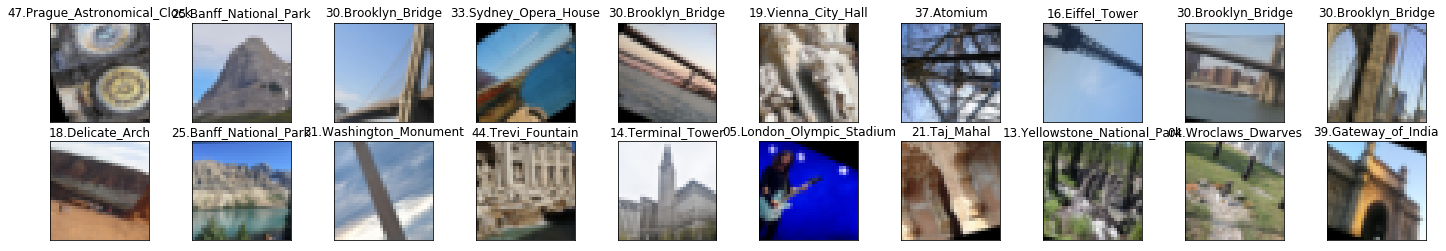

In [2]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_data.classes[labels[idx]])



### Initialize use_cuda variable

In [20]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [8]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.003)
    
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [9]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 50)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
        
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
                
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  Since the target accuracy was only 20%, I decided to do only 3 convolutional layers with max pooling and two linear layers. For each convolutional layer I applied ReLU activation and Max Pooling. In the linear layers I applied ReLU and dropout.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [21]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    with active_session(): #to keep vm workspace alive for more than 30 minutes
        for epoch in range(1, n_epochs+1):
            # initialize variables to monitor training and validation loss
            train_loss = 0.0
            valid_loss = 0.0

            ###################
            # train the model #
            ###################
            # set the module to training mode
            model.train()
            #for batch_idx, (data, target) in enumerate(loaders['train']):
            for batch_idx, (data, target) in enumerate(tqdm(loaders['train'], desc="Train")):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                ## TODO: find the loss and update the model parameters accordingly
                ## record the average training loss, using something like
                ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the loss
                loss = criterion(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                # update running training loss
                #train_loss += loss.item()*data.size(0)
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))            

            ######################    
            # validate the model #
            ######################
            # set the model to evaluation mode
            model.eval()
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(tqdm(loaders['valid'], desc="Valid")):
                    # move to GPU
                    if use_cuda:
                        data, target = data.cuda(), target.cuda()

                    ## TODO: update average validation loss 
                    # forward pass: compute predicted outputs by passing inputs to the model
                    output = model(data)
                    # calculate the loss
                    loss = criterion(output, target)
                    # update average validation loss 
                    valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))   
            model.train()


            # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

            ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [11]:
def custom_weight_init(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0,y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.864449 	Validation Loss: 3.816457
Validation loss decreased (inf --> 3.816457).  Saving model ...
Epoch: 2 	Training Loss: 3.758711 	Validation Loss: 3.771948
Validation loss decreased (3.816457 --> 3.771948).  Saving model ...
Epoch: 3 	Training Loss: 3.716729 	Validation Loss: 3.707064
Validation loss decreased (3.771948 --> 3.707064).  Saving model ...
Epoch: 4 	Training Loss: 3.639938 	Validation Loss: 3.673233
Validation loss decreased (3.707064 --> 3.673233).  Saving model ...
Epoch: 5 	Training Loss: 3.622358 	Validation Loss: 3.696575
Epoch: 6 	Training Loss: 3.585506 	Validation Loss: 3.572957
Validation loss decreased (3.673233 --> 3.572957).  Saving model ...
Epoch: 7 	Training Loss: 3.546936 	Validation Loss: 3.580841
Epoch: 8 	Training Loss: 3.502914 	Validation Loss: 3.567025
Validation loss decreased (3.572957 --> 3.567025).  Saving model ...
Epoch: 9 	Training Loss: 3.465799 	Validation Loss: 3.490361
Validation loss decreased (3.567025 --> 3.

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [12]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.884839 	Validation Loss: 3.852400
Validation loss decreased (inf --> 3.852400).  Saving model ...
Epoch: 2 	Training Loss: 3.799086 	Validation Loss: 3.767235
Validation loss decreased (3.852400 --> 3.767235).  Saving model ...
Epoch: 3 	Training Loss: 3.756454 	Validation Loss: 3.699753
Validation loss decreased (3.767235 --> 3.699753).  Saving model ...
Epoch: 4 	Training Loss: 3.706985 	Validation Loss: 3.669797
Validation loss decreased (3.699753 --> 3.669797).  Saving model ...
Epoch: 5 	Training Loss: 3.637062 	Validation Loss: 3.655949
Validation loss decreased (3.669797 --> 3.655949).  Saving model ...
Epoch: 6 	Training Loss: 3.579320 	Validation Loss: 3.569531
Validation loss decreased (3.655949 --> 3.569531).  Saving model ...
Epoch: 7 	Training Loss: 3.527826 	Validation Loss: 3.484209
Validation loss decreased (3.569531 --> 3.484209).  Saving model ...
Epoch: 8 	Training Loss: 3.507056 	Validation Loss: 3.499686
Epoch: 9 	Training Loss: 3.473520 

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(loaders['test'], desc="Test")):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
    model.train()
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [13]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.881445


Test Accuracy: 27% (338/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [23]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [24]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.Adam(model.classifier.parameters(), lr=0.003)
 

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [35]:
## TODO: Specify model architecture

#model_transfer = models.vgg16(pretrained=True)
model_transfer = models.densenet121(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False

#vgg16_transfer_classifier = nn.Sequential(nn.Linear(25088,4096),
 #                               nn.ReLU(),
  #                              nn.Dropout(0.2),
   #                             nn.Linear(4096,1024),
    #                            nn.ReLU(),
     #                           nn.Dropout(0.2),
      #                          nn.Linear(1024,256),
       #                        nn.Dropout(0.2),
        #                        nn.Linear(256, len(train_data.classes))#,
                                #nn.LogSoftmax(dim=1)
         #                       )

model_transfer.classifier = nn.Sequential(nn.Linear(1024,256),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(256, 50)#,
                                #nn.LogSoftmax(dim=1)
                                         )

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth

100%|██████████| 32342954/32342954 [00:00<00:00, 41585613.82it/s]

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I decided to use DenseNet121 as the pretrained network. I replaced the classifier with with my own linear classifier of one hidden layer with ReLU and dropout applied. I used an Adam optimizer and CrossEntropyLoss. I think this architecture is suitable because the landmark images training data in this project are similar to images of that the pretrained network was trained on. So we can use transfer learning, freeze the parameters of the pretrained network, and train a fresh linear classifier on the 50 specific landmarks we care about for this project.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [36]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

model_transfer = train(20, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')



Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 3.128393 	Validation Loss: 2.201376
Validation loss decreased (inf --> 2.201376).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 2.277297 	Validation Loss: 1.942993
Validation loss decreased (2.201376 --> 1.942993).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2.111452 	Validation Loss: 1.852329
Validation loss decreased (1.942993 --> 1.852329).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 2.000038 	Validation Loss: 1.671742
Validation loss decreased (1.852329 --> 1.671742).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.915857 	Validation Loss: 1.648367
Validation loss decreased (1.671742 --> 1.648367).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.809270 	Validation Loss: 1.685570


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.853353 	Validation Loss: 1.607775
Validation loss decreased (1.648367 --> 1.607775).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.784432 	Validation Loss: 1.562507
Validation loss decreased (1.607775 --> 1.562507).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.768885 	Validation Loss: 1.589955


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.728390 	Validation Loss: 1.546773
Validation loss decreased (1.562507 --> 1.546773).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.713937 	Validation Loss: 1.594082


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 1.746919 	Validation Loss: 1.605751


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 1.699865 	Validation Loss: 1.554291


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 1.693654 	Validation Loss: 1.497174
Validation loss decreased (1.546773 --> 1.497174).  Saving model ...


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 1.688306 	Validation Loss: 1.531321


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 1.675036 	Validation Loss: 1.538859


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 1.605751 	Validation Loss: 1.505910


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 1.642499 	Validation Loss: 1.513065


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 1.631020 	Validation Loss: 1.593106


Valid: 100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

Epoch: 20 	Training Loss: 1.634061 	Validation Loss: 1.693311


In [37]:
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [38]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test: 100%|██████████| 63/63 [00:24<00:00,  3.02it/s]

Test Loss: 1.027286


Test Accuracy: 72% (900/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [57]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path)

    img_transformed = test_transforms(img)
    img_transformed = img_transformed.unsqueeze(0)
    
    ##
    # in progress below
    ##
    model_transfer.eval()
    with torch.no_grad(): 
        if use_cuda:
            img_transformed = img_transformed.cuda()
        img_pred = model_transfer(img_transformed)
        img_pred = img_pred.unsqueeze(0)
    
    model_transfer.train()

    top_values, top_indices = torch.topk(img_pred, k, largest=True, sorted=True)
    prediction_indices = top_indices[0][0].tolist()
    predictions = []
    for pred_idx in prediction_indices:
        predictions.append(train_data.classes[pred_idx][3:].replace('_', ' '))
    return predictions

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Forth Bridge',
 'Golden Gate Bridge',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge',
 'Eiffel Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the Forth Bridge, Golden Gate Bridge, or Brooklyn Bridge?


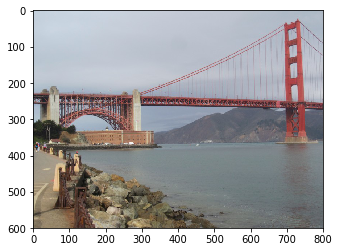

In [58]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    plt.imshow(Image.open(img_path))
    print("Is this picture of the {}, {}, or {}?".format(
        predicted_landmarks[0],
        predicted_landmarks[1],
        predicted_landmarks[2]))

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output was better than I expected! It's really neat to see my own photos--with or without people--be predicted correctly by the network.

1. I would use random translation instead of random rotation in the training transform preprocessing. I think most landmark images are probably not rotated. They are probably always taken straight up and down but shifted laterally or vertically in the image depending on the zoom of the camera.
1. I would train with and without people, with and without animals.
1. I would train with higher and lower exposure, to simulate morning, noon, and evening photos, and sunny and cloudy weather.

Is this picture of the Seattle Japanese Garden, Central Park, or Ljubljana Castle?


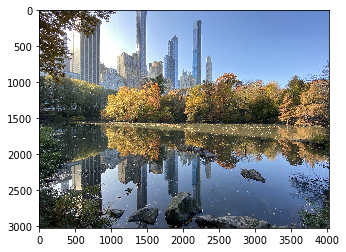

In [68]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('images/BP-CP.jpg')


Is this picture of the Brooklyn Bridge, Temple of Heaven, or Washington Monument?


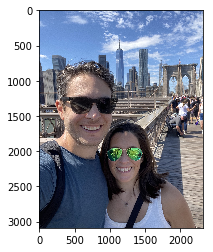

In [69]:
suggest_locations('images/BP-BB.jpg')

Is this picture of the Grand Canyon, Badlands National Park, or Death Valley National Park?


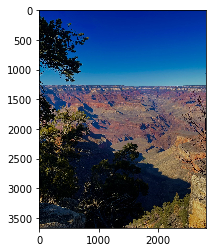

In [70]:
suggest_locations('images/BP-Grand-Canyon.jpg')

Is this picture of the Golden Gate Bridge, Great Barrier Reef, or Washington Monument?


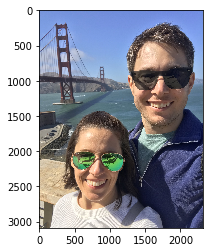

In [71]:
suggest_locations('images/BP-GGB.jpg')